In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import numpy as np
import itertools
from tqdm import trange
import scipy.sparse
import numpy.testing as npt
from integration_helpers import normalize_by_gene_length, sanitize_adata, validate_adata, add_doublet_annotation, undo_log_norm
from threadpoolctl import threadpool_limits
from tqdm.contrib.concurrent import process_map

In [2]:
threadpool_limits(8)

In [3]:
sc.set_figure_params(figsize=(5, 5))

In [4]:
annotated_datasets = {
    "Maynard_Bivona_2020_NSCLC": sc.read_h5ad("../../data/30_annotate_scrnaseq_data/maynard_annotated.h5ad"),
    "Lambrechts_2018_LUAD_6653" : sc.read_h5ad("../../data/30_annotate_scrnaseq_data/lambrechts_annotated.h5ad")
}

In [5]:
datasets = {
    "Maynard_Bivona_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Maynard_Bivona_2020_NSCLC/Maynard_Bivona_2020_NSCLC.qc.h5ad"),
    "Lambrechts_2018_LUAD_6653": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Lambrechts_2018_LUAD_6653/Lambrechts_2018_LUAD_6653.qc.h5ad"),
    "Adams_Kaminski_2020_COPD": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Adams_Kaminski_2020_COPD/Adams_Kaminski_2020_COPD.qc.h5ad"),
    "Goveia_Carmeliet_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Goveia_Carmeliet_2020_NSCLC/Goveia_Carmeliet_2020_NSCLC.qc.h5ad"),
    "Guo_Zhang_2018_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Guo_Zhang_2018_NSCLC/Guo_Zhang_2018_NSCLC.qc.h5ad"),
    "Lambrechts_2018_LUAD_6149": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Lambrechts_2018_LUAD_6149/Lambrechts_2018_LUAD_6149.qc.h5ad"),
    "Laughney_Massague_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Laughney_Massague_2020_NSCLC/Laughney_Massague_2020_NSCLC.qc.h5ad"),
    "Lukassen_Eils_2020_LUAD": sc.read_h5ad("../../data/10_public_datasets/Lukassen_Eils_2020_LUAD/h5ad_processed/lukassen20_lung_orig.processed.h5ad"),
    "Madissoon_Meyer_2020_pulmonary-fibrosis" : sc.read_h5ad("../../data/10_public_datasets/Madissoon_Meyer_2020_pulmonary-fibrosis/h5ad_processed/madissoon19_lung.processed.h5ad"),
    "Maier_Merad_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Maier_Merad_2020_NSCLC/Maier_Merad_2020_NSCLC.qc.h5ad"),
    "Mayr_Schiller_2020_pulmonary-fibrosis": sc.read_h5ad("../../data/10_public_datasets/Mayr_Schiller_2020_pulmonary-fibrosis/h5ad/integrated_human_dataset.h5ad"),
    "Pircher_batch1_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/batch1_3patients/batch1_3patients.qc.h5ad")
}

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [6]:
doublet_files = {
    "Adams_Kaminski_2020_COPD": "../../data/20_qc_norm_scrnaseq/02_solo/Adams_Kaminski_2020_COPD/Adams_Kaminski_2020_COPD.is_doublet.csv",
    "Goveia_Carmeliet_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Goveia_Carmeliet_2020_NSCLC/Goveia_Carmeliet_2020_NSCLC.is_doublet.csv",
   # No doublet filtering for smartseq2
   #  "Guo_Zhang_2018_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Guo_Zhang_2018_NSCLC/Guo_Zhang_2018_NSCLC.is_doublet.csv",
    "Lambrechts_2018_LUAD_6149": "../../data/20_qc_norm_scrnaseq/02_solo/Lambrechts_2018_LUAD_6149/Lambrechts_2018_LUAD_6149.is_doublet.csv",
    "Laughney_Massague_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Laughney_Massague_2020_NSCLC/Laughney_Massague_2020_NSCLC.is_doublet.csv",
    "Maier_Merad_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Maier_Merad_2020_NSCLC/Maier_Merad_2020_NSCLC.is_doublet.csv",
    "Pircher_batch1_NSCLC":"../../data/20_qc_norm_scrnaseq/02_solo/batch1_3patients/batch1_3patients.is_doublet.csv"
}

### Add doublet information and filter datasets

... storing 'is_doublet' as categorical


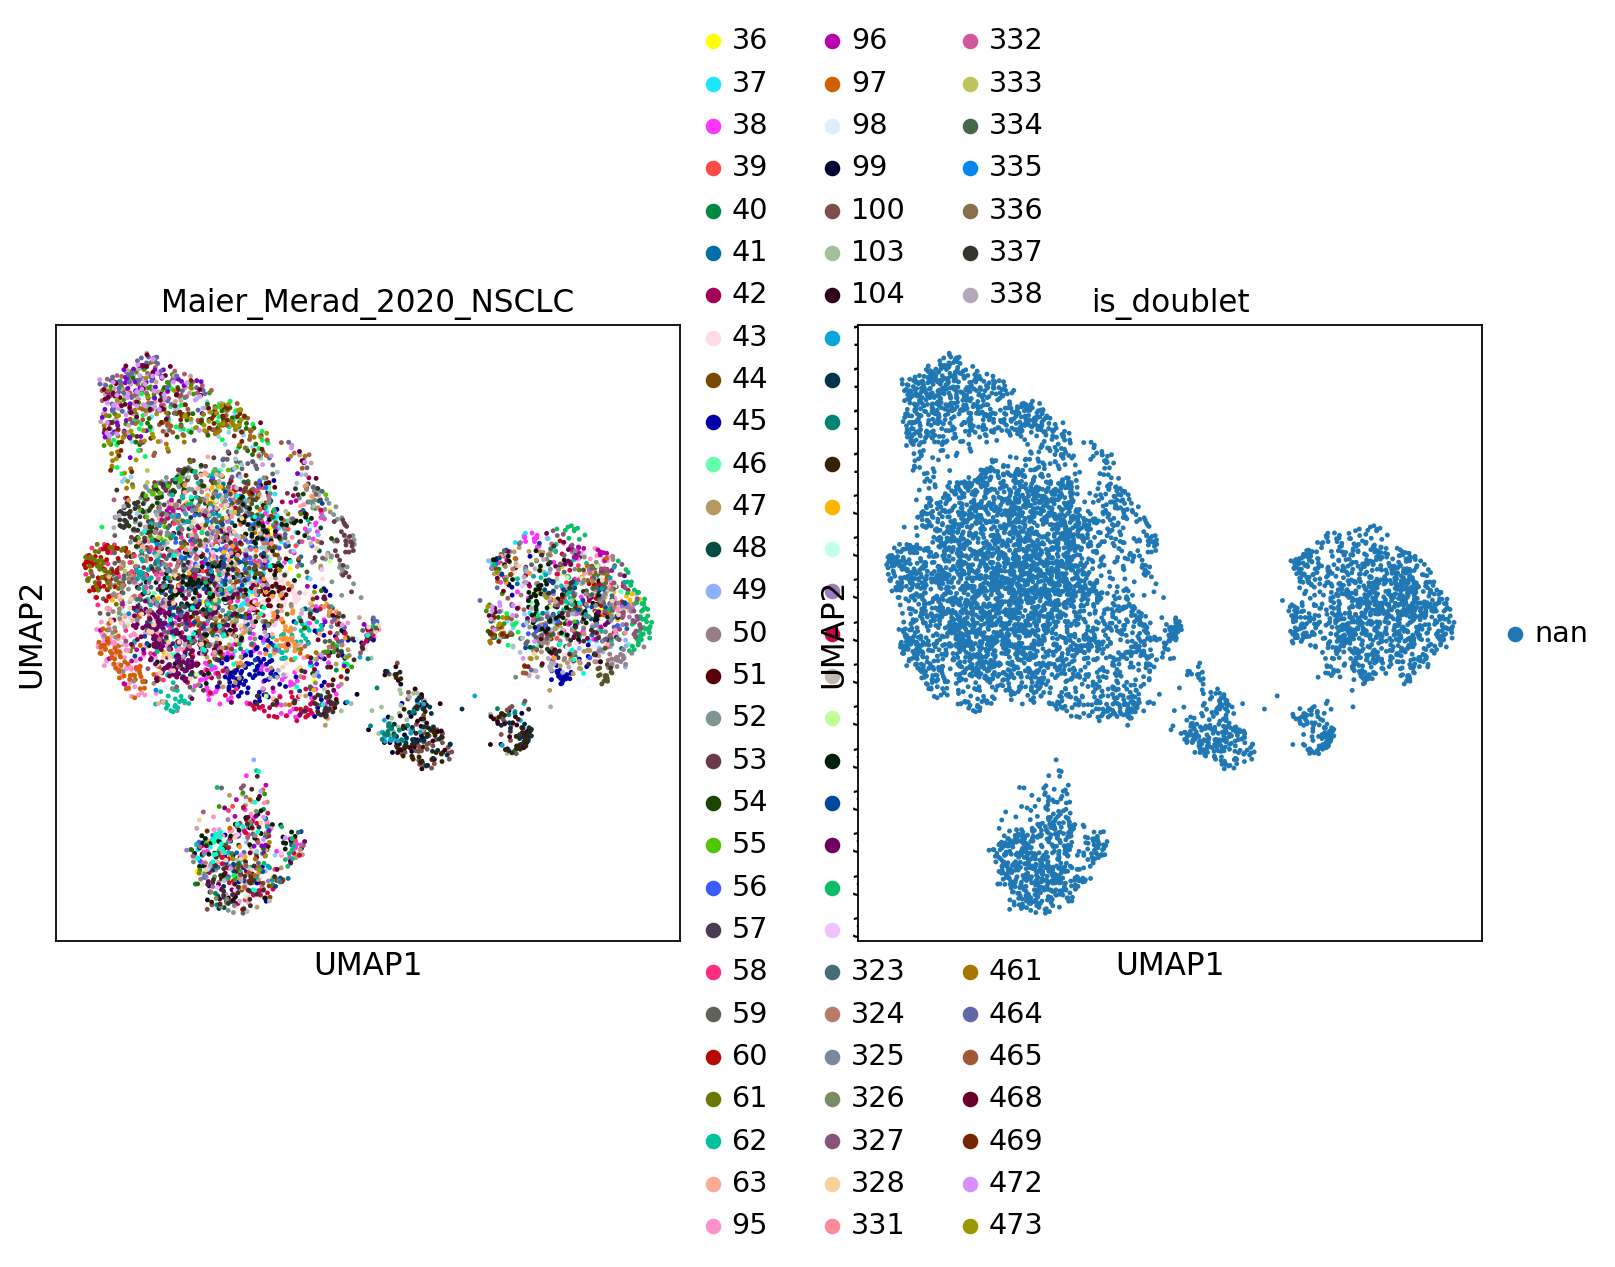

... storing 'is_doublet' as categorical


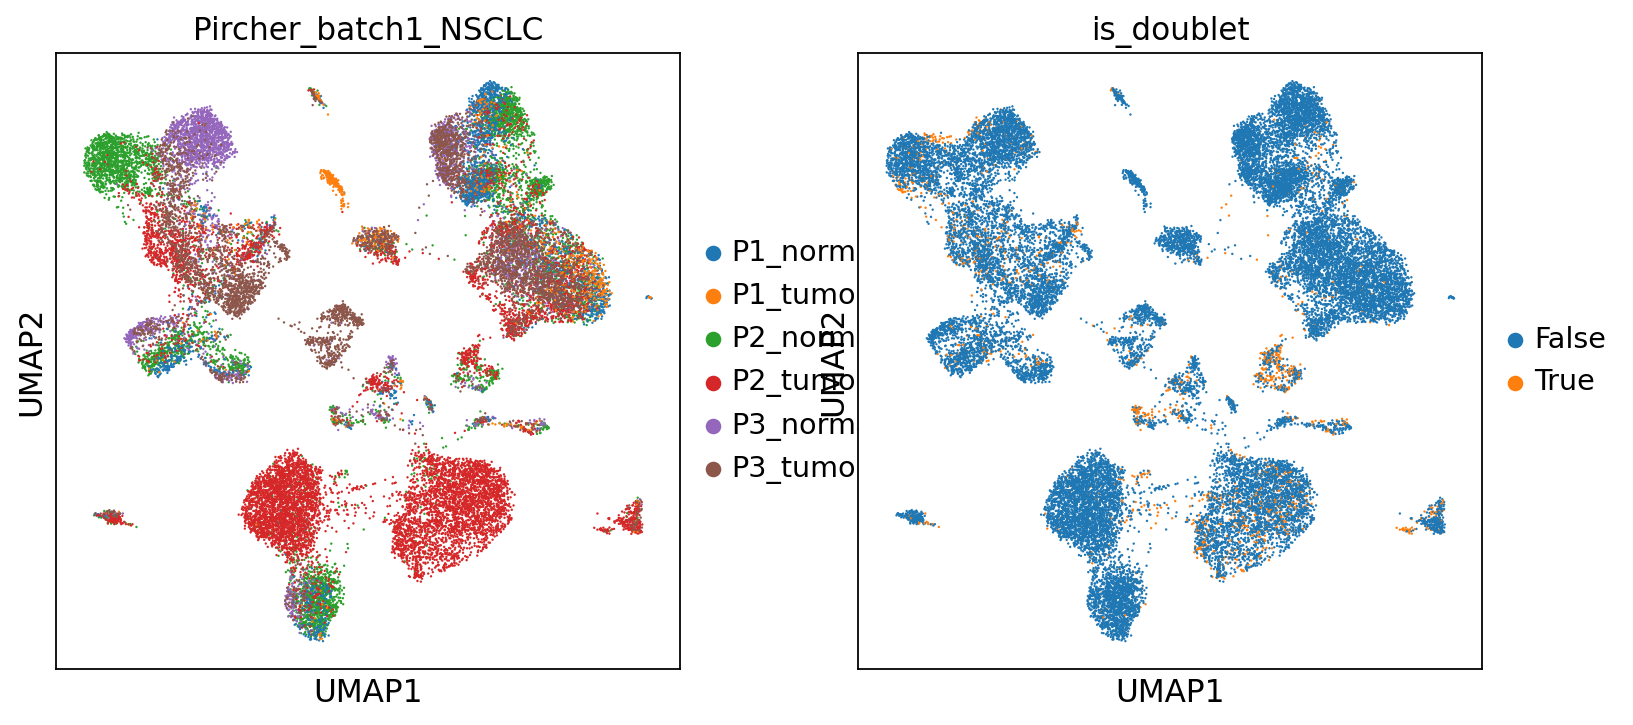

... storing 'is_doublet' as categorical


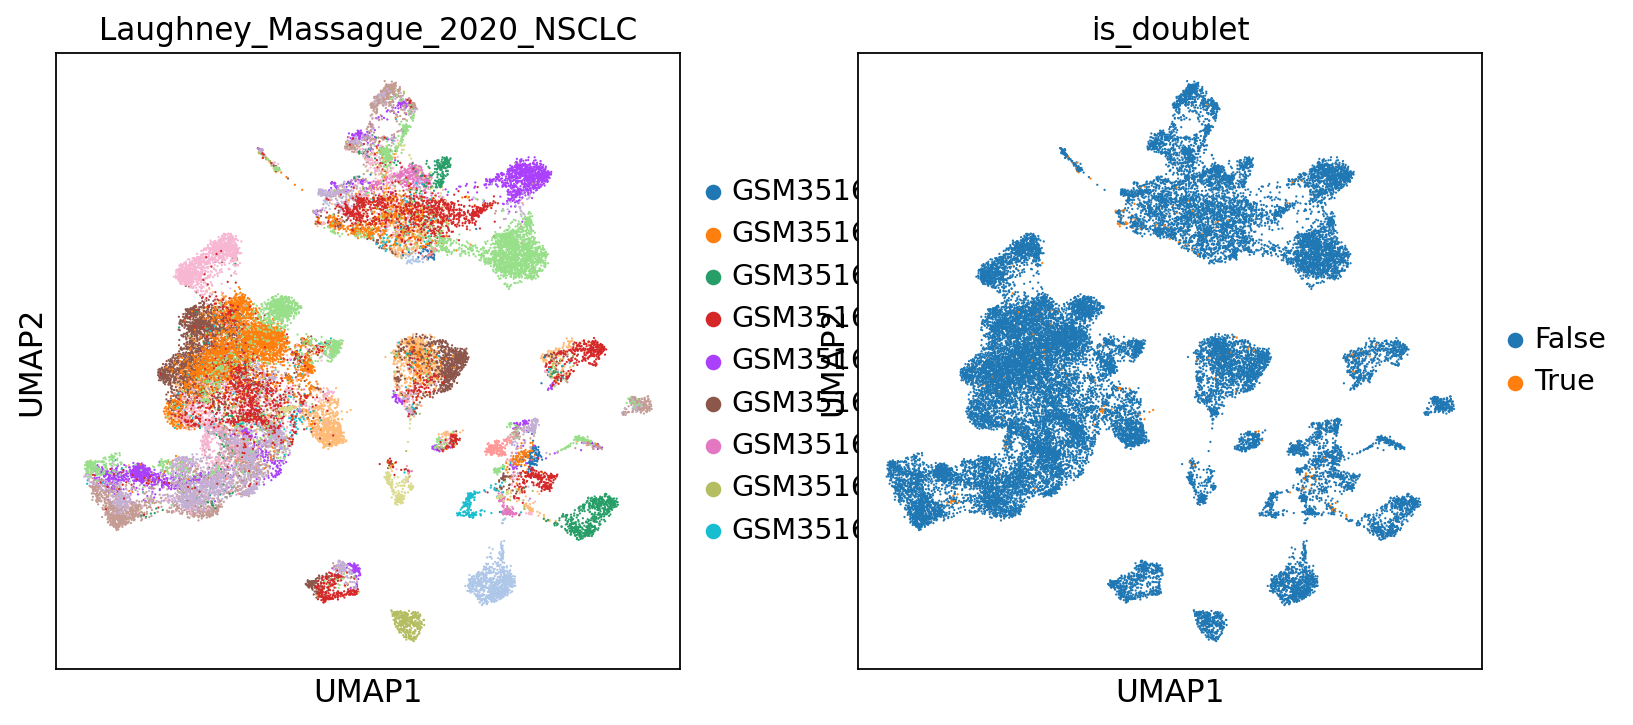

... storing 'is_doublet' as categorical


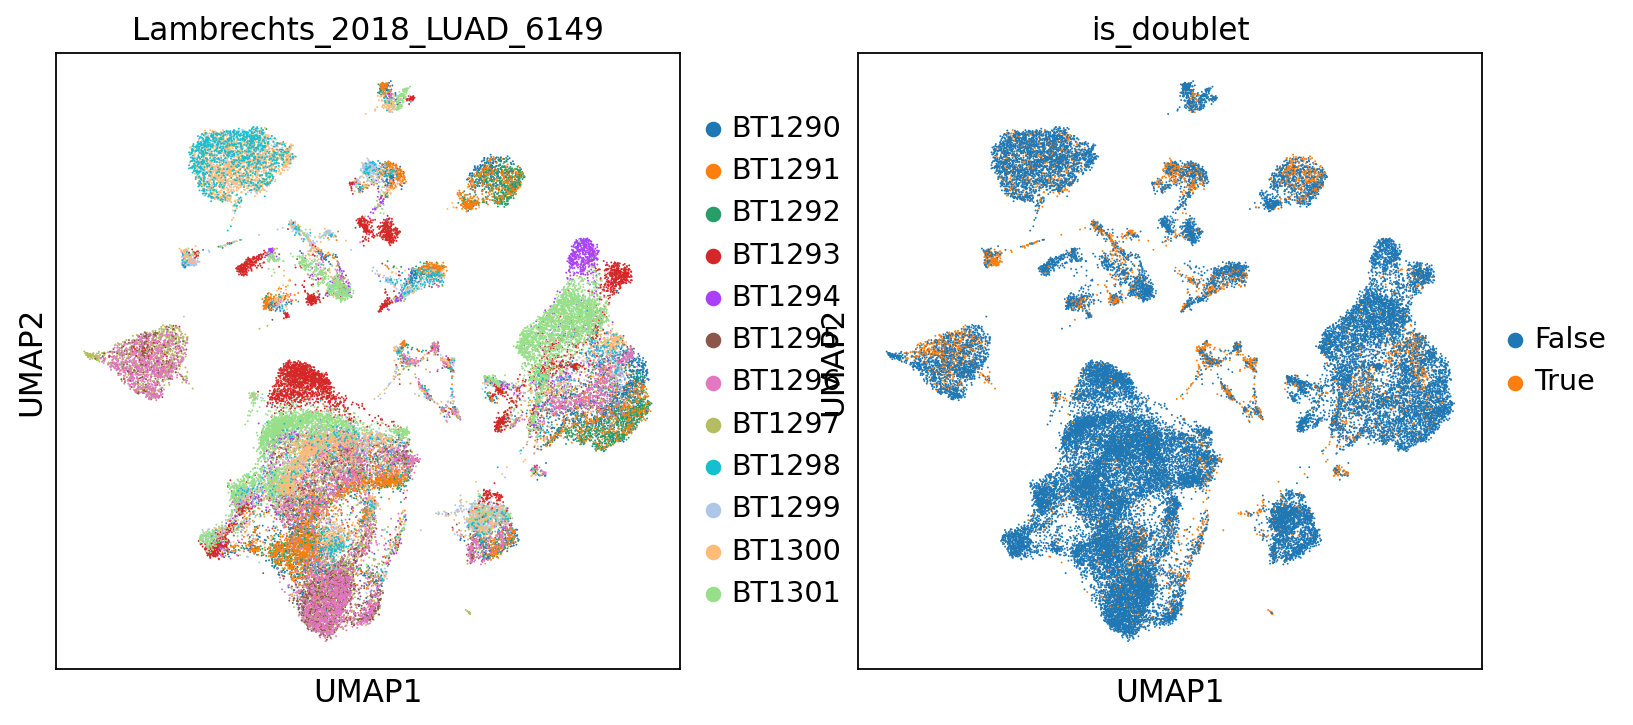

... storing 'is_doublet' as categorical


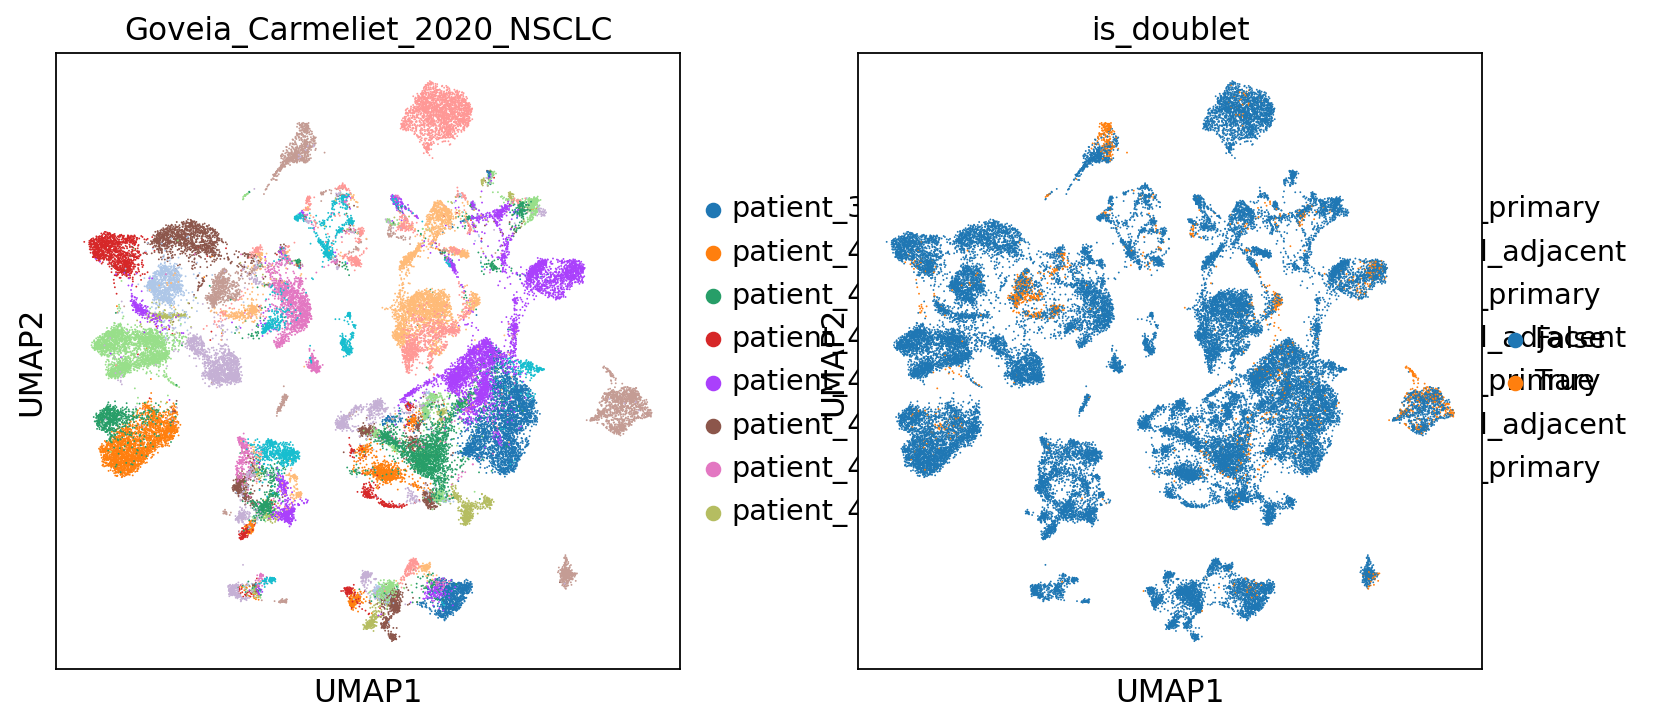

Process ForkProcess-4:
Process ForkProcess-6:
Process ForkProcess-3:
Process ForkProcess-2:
Process ForkProcess-5:
Process ForkProcess-10:
Process ForkProcess-12:
Process ForkProcess-14:
Process ForkProcess-8:
Process ForkProcess-11:
Process ForkProcess-7:
Process ForkProcess-9:
Traceback (most recent call last):
Process ForkProcess-15:
Traceback (most recent call last):
  File "/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkProcess-16:
  File "/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback 

KeyboardInterrupt: 

In [7]:
datasets_vis = process_map(add_doublet_annotation, [datasets[k] for k in doublet_files], doublet_files.values(), doublet_files.keys(), max_workers=16)

In [ ]:
for dataset_id, dataset in datasets.items():
    datasets[dataset_id] = dataset[dataset["is_doublet"] == "False", :].copy()

### Dataset-specific filtering and metadata fixes

In [ ]:
datasets["Maynard_Bivona_2020_NSCLC"] = normalize_by_gene_length(datasets["Maynard_Bivona_2020_NSCLC"])

In [ ]:
datasets["Adams_Kaminski_2020_COPD"].obs["origin"] = "normal"
datasets["Adams_Kaminski_2020_COPD"].obs["sex"] = "nan"
datasets["Adams_Kaminski_2020_COPD"] = datasets["Adams_Kaminski_2020_COPD"][datasets["Adams_Kaminski_2020_COPD"].obs["condition"] != "IPF", :]

In [ ]:
datasets["Goveia_Carmeliet_2020_NSCLC"] = datasets["Goveia_Carmeliet_2020_NSCLC"][datasets["Goveia_Carmeliet_2020_NSCLC"].obs["condition"] != 'LLCC'].copy()
datasets["Goveia_Carmeliet_2020_NSCLC"].obs["sex"] = "nan"

In [ ]:
datasets["Guo_Zhang_2018_NSCLC"] = datasets["Guo_Zhang_2018_NSCLC"][datasets["Guo_Zhang_2018_NSCLC"].obs["tissue"] != 'blood'].copy()
datasets["Guo_Zhang_2018_NSCLC"] = normalize_by_gene_length(datasets["Guo_Zhang_2018_NSCLC"])
datasets["Guo_Zhang_2018_NSCLC"].obs["sex"] = "nan"

In [ ]:
datasets["Laughney_Massague_2020_NSCLC"].obs["sex"] = "nan"

In [ ]:
undo_log_norm(datasets["Lukassen_Eils_2020_LUAD"])
datasets["Lukassen_Eils_2020_LUAD"].obs["sex"] = [{"M": "male", "F": "female"}[s] for s in datasets["Lukassen_Eils_2020_LUAD"].obs["sex"]]

In [ ]:
tmp_obs = datasets["Lukassen_Eils_2020_LUAD"].obs
tmp_obs["patient"] = tmp_obs["orig.ident"]
tmp_obs["sample"] = tmp_obs["orig.ident"]
tmp_obs["tissue"] = "lung"
tmp_obs["origin"] = "normal"
tmp_obs["condition"] = "LUAD"

In [ ]:
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["tissue"] = "lung"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["origin"] = "normal"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["condition"] = "healthy_control"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["sex"] = "nan"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].X.data = np.rint(datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].X.data)

In [ ]:
datasets["Maier_Merad_2020_NSCLC"].obs["sex"] = "nan"

In [ ]:
tmp_obs = datasets["Mayr_Schiller_2020_pulmonary-fibrosis"].obs
tmp_obs["sex"] = [{"M": "male", "F": "female"}[s] for s in tmp_obs["Sex"]]
tmp_obs["condition"] = [{"control donor": "healthy_control", "endstage lung fibrosis": "pulmonary_fibrosis"}[d] for d in tmp_obs["health_status"]]
tmp_obs["patient"] = tmp_obs["patient_id"]
tmp_obs["sample"] = tmp_obs["patient_id"]
tmp_obs["tissue"] = "lung"
tmp_obs["origin"] = "normal"

datasets["Mayr_Schiller_2020_pulmonary-fibrosis"] = datasets["Mayr_Schiller_2020_pulmonary-fibrosis"][datasets["Mayr_Schiller_2020_pulmonary-fibrosis"].obs["condition"] != "pulmonary_fibrosis", :].copy()

### Validate data

In [ ]:
for dataset_id, adata in datasets.items():
    print(f"Validating {dataset_id}")
    adata.obs["dataset"] = dataset_id
    sanitize_adata(adata)
    validate_adata(adata)